In [4]:
install.packages("plyr")

library(tidyverse)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [5]:
library(plyr)

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact




In [6]:
install.packages("scales")
install.packages("latex2exp")
library(scales)
library(latex2exp)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




# Bayesian Blocks


# 1. Introduction

#1.1) But what is Bayesian Blocks ?
The **Bayesian Blocks** algorithm enhances **histogram binning** by determining optimal **data segmentation** within the observation interval. It
is a method designed to analyze **time-series data** by identifying change points where the data's statistical properties change significantly This method accurately represents the underlying data distribution, distinguishing statistically significant features from random fluctuations. Implemented in R, its performance has been evaluated using various datasets.


# 1.2) Data Representation Via Histograms
Histograms are essential in data analysis, used to **identify and characterize** statistically significant variations within datasets. Traditionally, ranges and bin widths are selected subjectively to create aesthetically pleasing plots.

 Methods like Scott’s Rule optimize binning for normally distributed random samples, while others consider distribution structure but **use fixed-width bins** or aim for equal entries per bin with arbitrarily chosen bin edges. These approaches, however, have limitations.

The Bayesian Blocks algorithm addresses these limitations by allowing variable bin widths, determining bin edges based on the data structure. This results in histograms that better capture the true data distribution.

### References
- Scargle, J. D., et al. (2013). "Studies in Astronomical Time Series Analysis. VI. Bayesian Block Representations." The Astrophysical Journal.



## 2) Our recepie : Bayesian Blocks
The key point here is to find ***the optimal segmentation of data*** by inferring the posterior probability :

##### **The Posterior Probability**:



 Using Bayes' theorem:
  
   $$P(\text{segmentation} \mid \text{data}) \propto P(\text{data} \mid \text{segmentation}) \times P(\text{segmentation})
   $$


we are going to talk about it in detail in this chapter






###2.1) Prior Distribution for the Number of Blocks


In the Bayesian Blocks approach, the prior probability distribution for the number of blocks, \( N_{blocks} \), plays a critical role. A ***flat prior***, as suggested by Scargle (1998), assumes equal likelihood for any number of blocks, which can be unrealistic in many contexts.


Instead, a  ***geometric prior*** was adopted  with parameter $\gamma$:


$$P(N_{blocks}) = P_0 \gamma^{N_{blocks}} $$

where $P_0$ is the normalization constant, which, once obtained, gives:

$$P(N_{blocks}) = \frac{1-\gamma}{1-\gamma^{N+1}} \gamma^{N_{blocks}}$$



It has well-understood properties and is simply implemented in the algorithm. $\gamma$ values are taken to be smaller than $1$ to avoid overfitting. Notice that putting $\gamma=1$ equals to using a flat prior for the bins.

Another possibility is to **calibrate the prior** as a function of the number of data points $N$ and the correct detection rate $p_0$ ($\equiv 1 - p_1$ false positive rate) on toy pure-noise experiments, leading to the expression:

$$ \texttt{ncp_prior} = 4 - \log(73.53 p_0 N^{-0.478})$$
### 2.2) Fitness Function $$ P(Data | Segmentation) $$
The fitness function in Bayesian Blocks is based on the likelihood of the data given a model \( M \). For unbinned event data following a Poisson distribution, the log-likelihood is:

$$
\log L(\theta) = \sum_n \log M(t_n, \theta) - \int M(t, \theta) dt
$$


Simplified Fitness Function for a Constant Model:

\$$log L^{(k)}(\lambda) = N^{(k)} \log \lambda - \lambda T^{(k)} $$


where $( N^{(k)})$ is the number of events in block $( k )$ and \( $T^{(k)} $\) is the length of the block. The maximum likelihood estimate for \( $\lambda$) is \( $\lambda = \frac{N^{(k)}}{T^{(k)}} $\), yielding:

$$
\log L^{(k)}_{\max} + N^{(k)} = N^{(k)} (\log N^{(k)} - \log T^{(k)})$$

In the following work, the data were considered to follow Cash statistics just as reported in Scargle 2013:

if $M(t, \theta)$ is the considered model of the time dependence of the signal, **the unbinned log-likelihood** is:

$$\log L(\theta) = \sum_n \log M(t_n, \theta) − \int M(t, \theta)dt$$

where the sum is over the events and $\theta$ represents the model
parameters. The integral is over the observation interval and
is the expected number of events under the model.

In the considered case, $M(t, \lambda) = \lambda$ (constant model), so for block $k$:

$$ \log L^{(k)}(\lambda) = N^{(k)}\log \lambda − \lambda T^{(k)}$$

where $N^{(k)}$ is the number of events in block $k$ and $T^{(k)}$ is
the length of the block. The maximum of this likelihood is at $\lambda = N^{(k)}/T^{(k)}$, yielding:


$$ \log L^{(k)}_{max}+ N^{(k)} = N^{(k)}(\log N^{(k)}− \log T^{(k)})$$

In this way the fitness function (i.e., the likelihood) will be:

- scale invariant : The fitness function doesn't change if we rescale the data
- block-additive : The total fitness is the sum of the fitness values for each block.


The fitness of the **entire partition** will be then:

$$
\log L = \sum_k \log L_{max}^{(k)}
$$



# 3 ) Algorithm

The number of possible partitions of data is $2^N$, hence computing all of them is very computationally demanding: a _dynamic programming_ approach is adopted, mimicking mathematical induction:

- we can easily find the optimal binning for a single point, which of course is the optimal one;
- we compute the optimal partition at each iteration from the previously computed ones (mathematical details in the appendices of Scargle 2013).

In this way, Scargle and collaborators showed that the $2^N$ possible states can be explored in $N^2$ time.


The advantage of the Bayesian Blocks algorithm lies in its ability to determine the optimal partitioning without needing to conduct an exhaustive search, which is impractical for nearly all real-world values of  $N$ . Indeed, this method guarantees that the global maximum fitness is obtained in $\pmb{O(N^2)}$, which is much more efficient than an exhaustive search of all $2^N$ potential configurations.




A brief review :


1) Define the function and specify parameters for the data, type, and priors.

Process the data:
If it's an array, sort it, get unique values, and count occurrences.
If it's a histogram, extract breaks and midpoints.
Initialize necessary variables, including edges and matrices to store fitness values and change points.


2) Define the fitness function**(Log-Fitness)** to measure how well segments fit the data.

3) Define priors(**Log-Prior:** This function defines the prior on the number of change points. The different priors **(uniform, gamma, and p0)** apply different penalties for adding change points, with p0 being a calibrated prior) for the number of change points.

4) Calculate the prior based on the selected type.

5) Iteratively find segments:
For each possible segment, calculate width and count.
Evaluate the fitness function and adjust by the prior.
Store the best change points.

6) Extract change points by backtracking from the end to the start.


This algorithm helps you identify the optimal points where the data should be segmented into different blocks, balancing between fitting the data well and avoiding overfitting with too many segments.









In [7]:
bayesian_blocks <- function(data, data_type='array', prior='p0', gamma=0.01, p0=0.01){

    # if data is an array of float
    if(data_type == 'array'){
        # load required library for function count func
        require(plyr)
        # take care of repeated data
        x_sorted <- sort(data)
        x_unique <- unique(x_sorted)
        x_weight <- count(x_sorted)$freq
    }
    else if(data_type == 'hist'){
        br <- data$breaks
        x_unique <- c(br[1], data$mids, br[length(br)])
        x_weight <- c(1, data$counts, 1)
    }
    else{
        stop('Error: data type must be an array')
    }

    # copy vector
    x <- x_unique
    N <- length(x)

    # create vector of cell edges
    edges <- c(x[1], 0.5 * (x[2:N] + x[1:(N-1)]), x[N])

    # create matrix needed for the iteration
    best   <- matrix(0, nrow=1, ncol=N)
    last   <- matrix(0, nrow=1, ncol=N)

    # the fitness function Calculates the fitness for a given segment.
    log_fitness <- function(N_k, T_k, string){
        return( N_k * ( log(N_k) - log(T_k) ) )
    }

    # pre-defined (log)prior distributions on the number of changepoints
    log_prior <- function(string){
        if(string == 'uniform'){
            return( 0 )
        }
        else if(string == 'gamma'){
            return( -log(gamma) )
        }
        else if(string == 'p0'){
            return( 4 - log(73.53 * p0 * N**(-0.478)) )
        }
        else{
            stop("Error: no available prior selected.")
        }
    }

    # prior on the number of blocks (cp), i.e. either uniform, gamma or calibrated prior
    ncp_prior <-  log_prior(string=prior)

    # Start with first data cell; add one cell at each iteration

    for(K in 1:N){
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width <- edges[K+1] - edges[1:K]
        count_vec <- rev(cumsum(x_weight[1:K]))

        # evaluate fitness function for these possibilities
        fit_vec <- log_fitness(N_k=count_vec, T_k=width, string=string_f)
        fit_vec <- fit_vec - ncp_prior
        fit_vec[2:K] <- fit_vec[2:K] + best[1:(K-1)]

        # find the max of the fitness, i.e. the K^th changepoint
        i_max <- which.max(fit_vec)

        # save best configuration
        last[K] <- i_max
        best[K] <- fit_vec[i_max]
    }

    # iteratively peel off the last block to retrieve the change points
    change_points <- matrix(0, nrow=1, ncol=N)
    i_cp <- N + 1
    ind <- N + 1

    while(TRUE){
        i_cp <- i_cp - 1
        change_points[i_cp] <- ind

        if(ind == 1){
            break
        }
        ind <- last[ind - 1]
    }

    change_points <- change_points[(i_cp):N]
    return(edges[change_points])
}


#Synthetic Data
##normal distribution


The synthetic data is created by combining two normal distributions:

The first set of data is generated with a mean of 0 and a standard deviation of 0.5.


The second set of data is generated with a mean of m and a standard deviation of s.




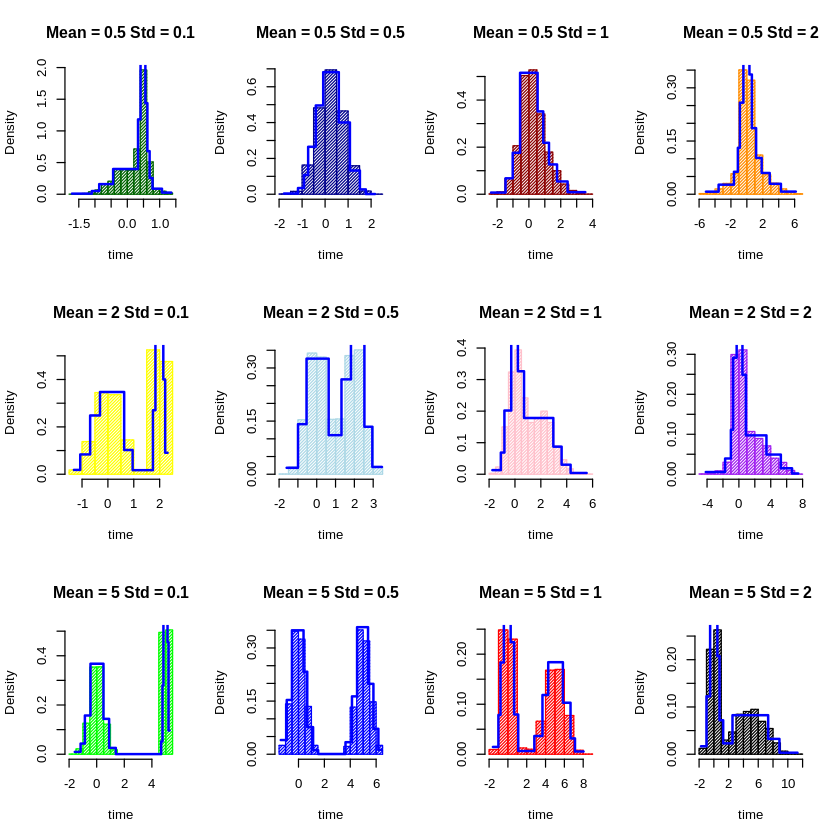

In [8]:
# Set up the plot layout
par(mfrow = c(3, 4))

# Define different mean and standard deviation combinations
mean_vals <- c(0.5, 2, 5)
std_vals <-  c(0.1, 0.5, 1, 2)

# Define a color palette
colors <- c("darkgreen", "darkblue", "darkred", "darkorange","yellow", "lightblue", "pink", "purple", "green", "blue", "red")

# Loop over each combination of mean and standard deviation
for (m in mean_vals){
    for (s in std_vals){

        # Generate two sets of normal distributions
        t.normal <- c(rnorm(1000, mean = 0, sd = 0.5), rnorm(1000, mean = m, sd = s))
        x.normal <- rep(1, 2000)

        # Compute Bayesian blocks
        edges.normal <- bayesian_blocks(t.normal)
        N.edges.normal <- length(edges.normal)

        # Compute steps for the step function
        steps.normal <- rep(0, N.edges.normal)
        for (K in seq_len(N.edges.normal)){
            steps.normal[K] <- sum(x.normal[t.normal >= edges.normal[K] & t.normal < edges.normal[K+1]]) / sum(x.normal * (edges.normal[K+1] - edges.normal[K]))
            if (K == N.edges.normal - 1) break
        }
        steps.normal[N.edges.normal] <- steps.normal[N.edges.normal - 1]
        # Set the size and position of the plots


        # Plot histogram and step function with unique color
        hist(t.normal, probability = TRUE, col = colors[(which(mean_vals == m) - 1) * 4 + which(std_vals == s)], density = 60, main = paste("Mean =", m, "Std =", s), xlab = "time")
        lines(edges.normal, steps.normal, type = "s", lwd = 2, col = "blue")
    }
}

# Reset the plotting parameters
par(mfrow = c(2, 2))


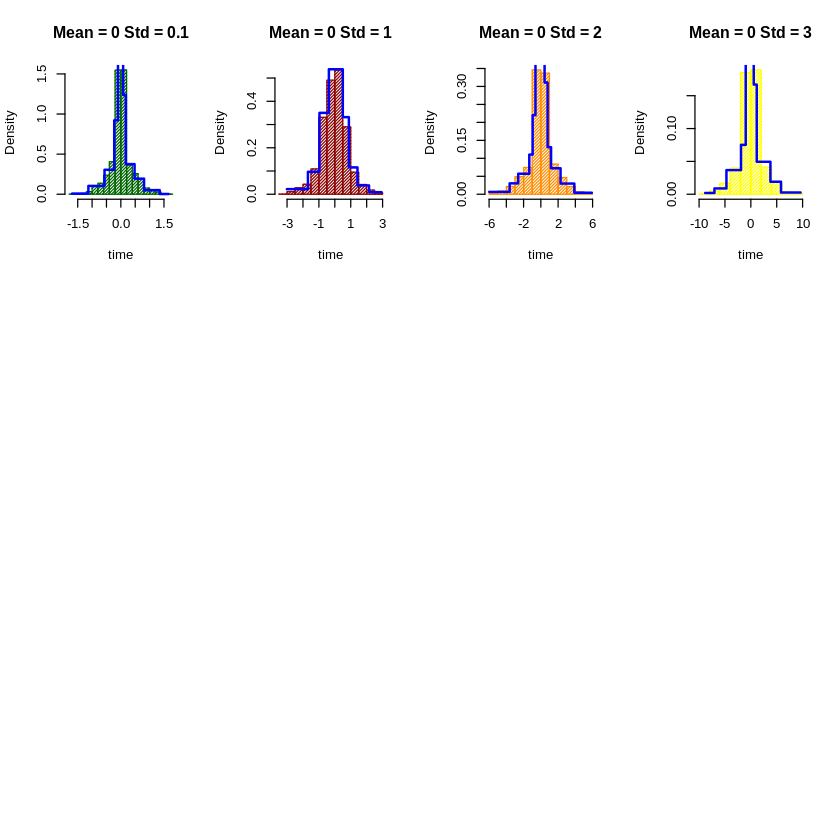

In [9]:
# Set up the plot layout
par(mfrow = c(3, 4))

# Define different mean and standard deviation combinations
mean_vals <- c(0)
std_vals <- c(0.1, 1, 2, 3)


# Define a color palette
colors <- c("darkgreen", "darkred", "darkorange","yellow")

# Loop over each combination of mean and standard deviation
for (m in mean_vals){
    for (s in std_vals){

        # Generate two sets of normal distributions
        t.normal <- c(rnorm(1000, mean = 0, sd = 0.5), rnorm(1000, mean = m, sd = s))
        x.normal <- rep(1, 2000)

        # Compute Bayesian blocks
        edges.normal <- bayesian_blocks(t.normal)
        N.edges.normal <- length(edges.normal)

        # Compute steps for the step function
        steps.normal <- rep(0, N.edges.normal)
        for (K in seq_len(N.edges.normal)){
            steps.normal[K] <- sum(x.normal[t.normal >= edges.normal[K] & t.normal < edges.normal[K+1]]) / sum(x.normal * (edges.normal[K+1] - edges.normal[K]))
            if (K == N.edges.normal - 1) break
        }
        steps.normal[N.edges.normal] <- steps.normal[N.edges.normal - 1]
        # Set the size and position of the plots


        # Plot histogram and step function with unique color
        hist(t.normal, probability = TRUE, col = colors[(which(mean_vals == m) - 1) * 4 + which(std_vals == s)], density = 60, main = paste("Mean =", m, "Std =", s), xlab = "time")
        lines(edges.normal, steps.normal, type = "s", lwd = 2, col = "blue")
    }
}

# Reset the plotting parameters
par(mfrow = c(2, 2))

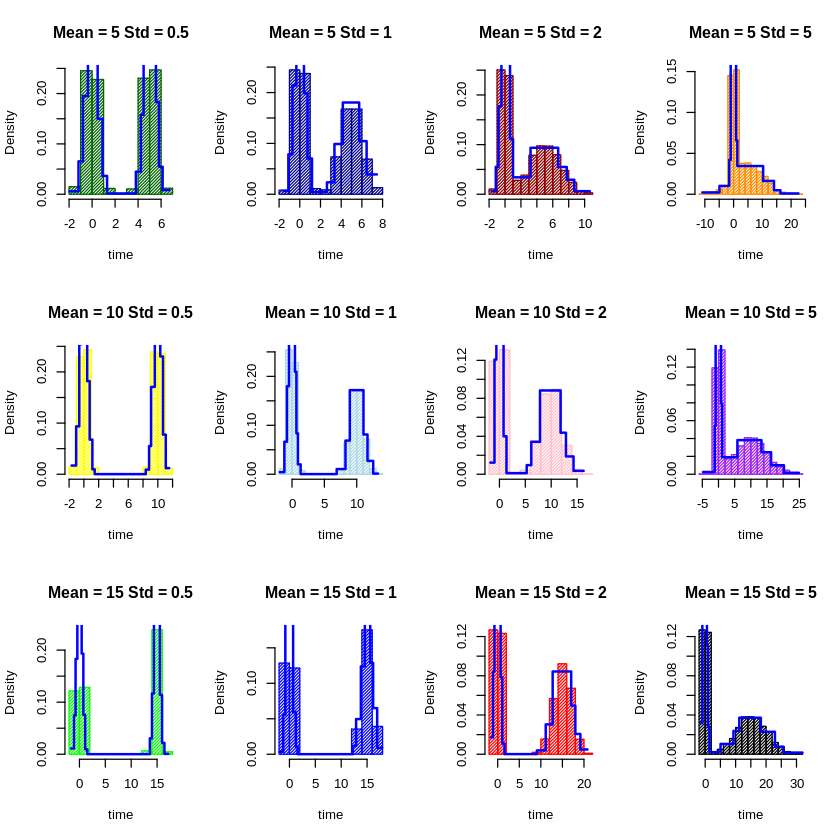

In [10]:
# Set up the plot layout
par(mfrow = c(3, 4))

# Define different mean and standard deviation combinations
mean_vals <- c(5, 10, 15)
std_vals <- c(0.5, 1, 2, 5)

# Define a color palette
colors <- c("darkgreen", "darkblue", "darkred", "darkorange","yellow", "lightblue", "pink", "purple", "green", "blue", "red")

# Loop over each combination of mean and standard deviation
for (m in mean_vals){
    for (s in std_vals){

        # Generate two sets of normal distributions
        t.normal <- c(rnorm(1000, mean = 0, sd = 0.5), rnorm(1000, mean = m, sd = s))
        x.normal <- rep(1, 2000)

        # Compute Bayesian blocks
        edges.normal <- bayesian_blocks(t.normal)
        N.edges.normal <- length(edges.normal)

        # Compute steps for the step function
        steps.normal <- rep(0, N.edges.normal)
        for (K in seq_len(N.edges.normal)){
            steps.normal[K] <- sum(x.normal[t.normal >= edges.normal[K] & t.normal < edges.normal[K+1]]) / sum(x.normal * (edges.normal[K+1] - edges.normal[K]))
            if (K == N.edges.normal - 1) break
        }
        steps.normal[N.edges.normal] <- steps.normal[N.edges.normal - 1]
        # Set the size and position of the plots


        # Plot histogram and step function with unique color
        hist(t.normal, probability = TRUE, col = colors[(which(mean_vals == m) - 1) * 4 + which(std_vals == s)], density = 60, main = paste("Mean =", m, "Std =", s), xlab = "time")
        lines(edges.normal, steps.normal, type = "s", lwd = 2, col = "blue")
    }
}

# Reset the plotting parameters
par(mfrow = c(2, 2))

## Application on a real dataset

Being the algorithm really flexible and easily applicable, the bayesian blocks method is applied to an energy spectrum, differently from what done in Scargle 2013, where only time based events are treated.

The dataset analysed is collected via a Germanium detector, and concerns the energy spectrum of a $Am241$, $ Co60$ and $Cs137$ radioactive source. In the experimental setting, the source was well sealed and hence we can consider the detected signals as photons emitted by $\gamma$ decay of the source, while the contribute of normally produced $\alpha$ particles can be considered negligible since they were absorbed by the sealing system.





# the dataset properties
The data come from the energy spectrum of radioactive sources (Am241, Co60, and Cs137) measured by a Germanium detector.
These spectra provide crucial information about the decay processes and energy emissions of radioactive materials, which are fundamental to nuclear physics and radiation detection.



###Comparison of Analytical Functions:

The dataset allows for the **comparison of the quality-of-fit for different analytical functions to γ-ray peaks**.
By testing various functions, researchers can determine which mathematical models best represent the observed data, even though none of them perfectly represent the physical processes.


###Detector Performance Analysis:

The data were collected from three different Ge(Li) and Ge detectors with varying volumes (13, 65, and 120 cm³).
This comparison helps in **understanding how detector volume and type affect the measurement** and accuracy of γ-ray spectra.
Such comparisons are essential for optimizing detector design and improving the accuracy of measurements.

In [12]:
# Load necessary libraries
library(ggplot2)

# Load data file and create a dataframe
filename <- "/content/B19036_AmCsCo_20180316.dat"
data <- read.table(filename, header=FALSE, sep='\n', skip=2, col.names='y', stringsAsFactors=FALSE)

# Check for missing values
if(any(is.na(data$y))) {
  cat('Missing values found, replacing with 0')
  data$y[is.na(data$y)] <- 0
}

# Add x column
data['x'] <- seq(0, nrow(data)-1)

# Display the length of the dataset
cat('Length dataset:', nrow(data), '\n')


Length dataset: 8192 


In [13]:
# Rearrange dataset
new_data <- rep(data$x, data$y)

# Display the length of the new dataset
cat('Length new dataset:', length(new_data), '\n')


Length new dataset: 3909541 


Warning message in xy.coords(x, y, xlabel, ylabel, log):
“2 y values <= 0 omitted from logarithmic plot”


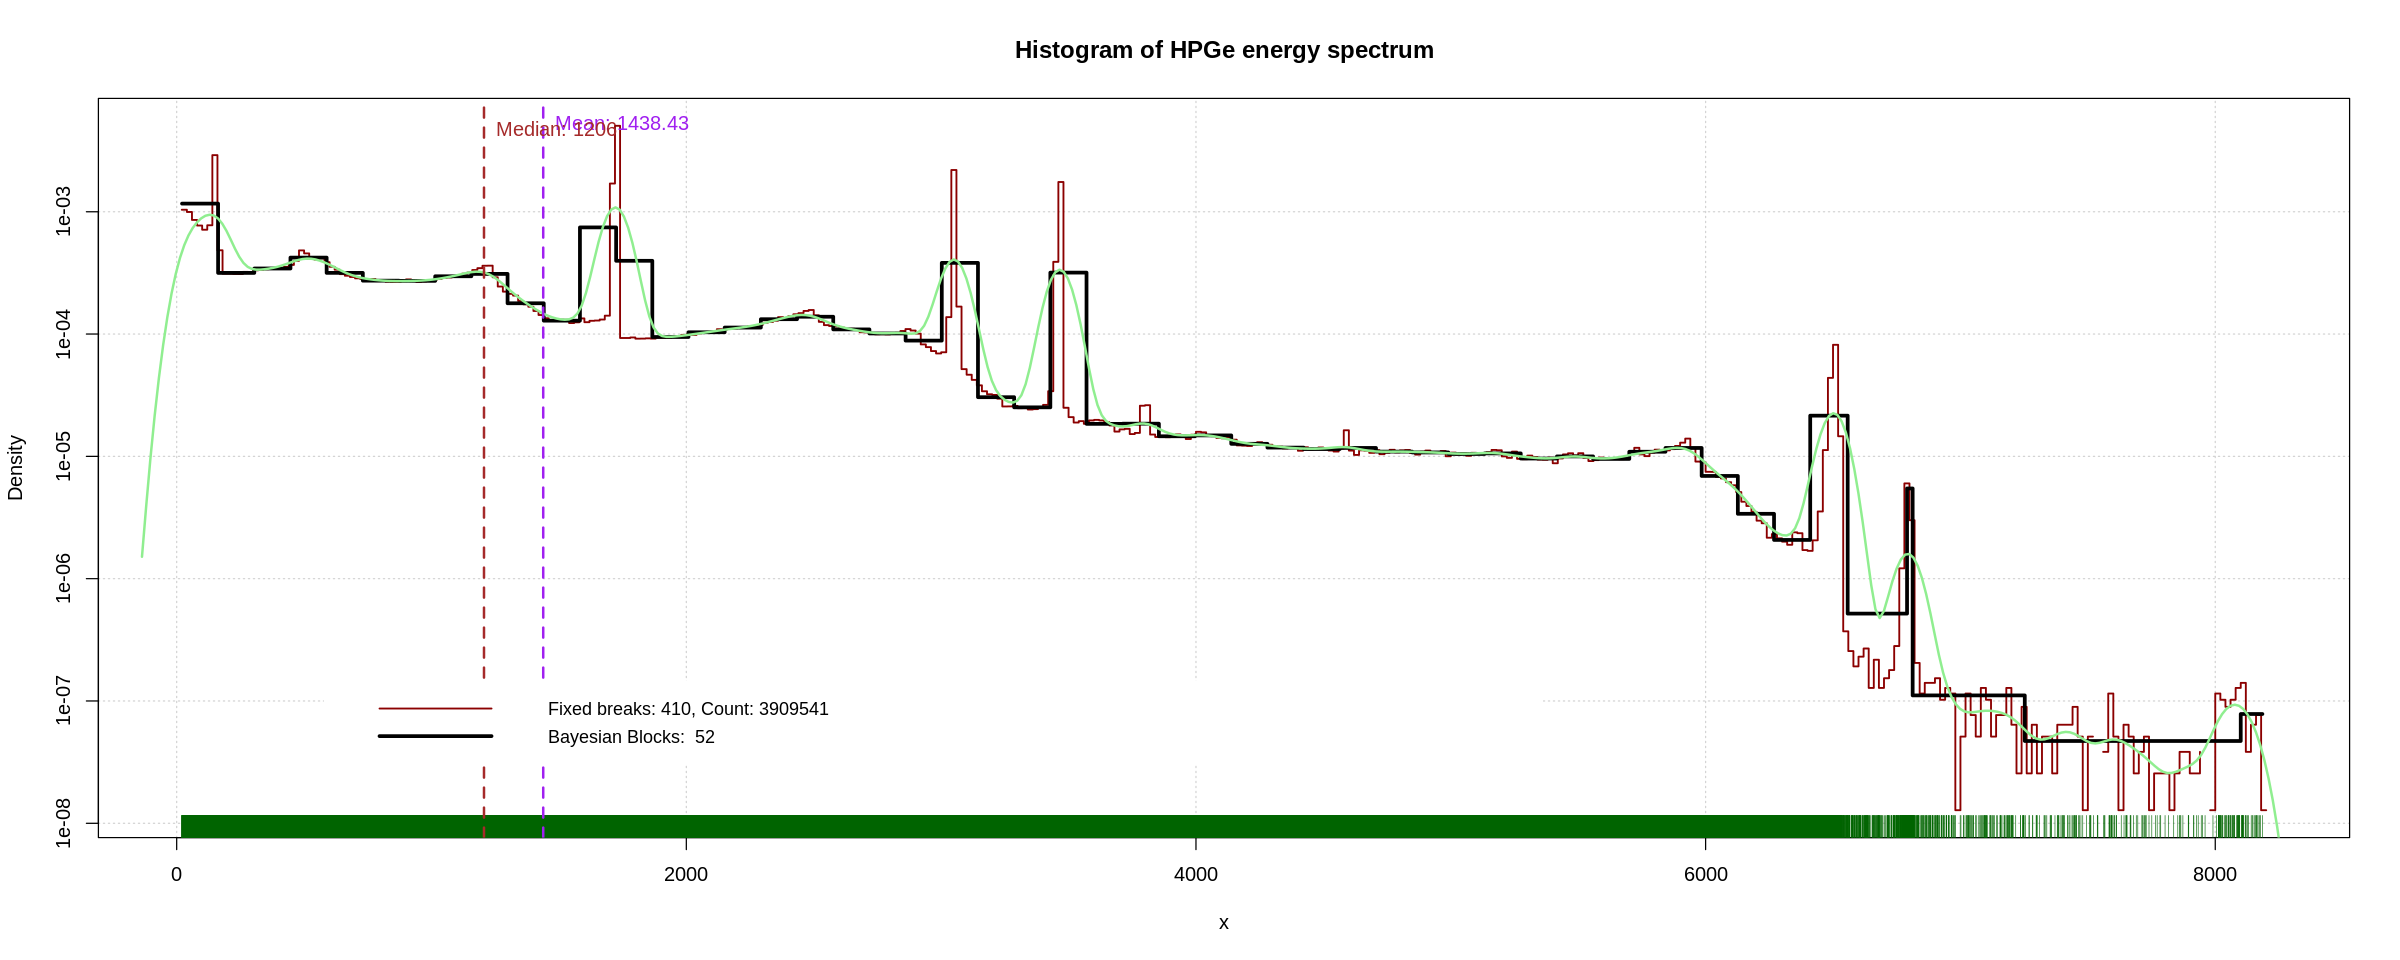

In [14]:
# We generate two histograms: one with a fixed number of breaks and one using the Bayesian Blocks algorithm.
h1 <- hist(new_data, breaks=500, plot=FALSE)

# Generate the histogram using Bayesian Blocks
gamma_value <- 1 # Adjust this value to see the effect
h2 <- hist(new_data, breaks=bayesian_blocks(new_data, data_type='array', gamma=gamma_value), plot=FALSE)

# Set up the plotting area
par(mfrow=c(1,1))
options(repr.plot.width=20, repr.plot.height=8)

# Plot the histogram with fixed breaks
plot(x=h1$breaks[1:length(h1$breaks)], y=c(h1$density, tail(h1$density, n=1)), log="y", panel.first=grid(),
     col="darkred", lwd=1.5, type='s', xlab='x', ylab='Density',
     main="Histogram of HPGe energy spectrum")

# Plot the histogram using Bayesian Blocks
lines(x=h2$breaks[1:length(h2$breaks)], y=c(h2$density, tail(h2$density, n=1)), type='s', lwd=3, col= "black")

# Add density curve
lines(density(new_data), col="lightgreen", lwd=2)

# Add rug plot
rug(new_data, col="darkgreen", lwd=0.5)

# Calculate mean and median
mean_value <- mean(new_data)
median_value <- median(new_data)

# Add annotations for mean and median
abline(v=mean_value, col="purple", lwd=2, lty=2)
abline(v=median_value, col="brown", lwd=2, lty=2)
text(mean_value, max(h1$density), labels=paste("Mean:", round(mean_value, 2)), pos=4, col="purple")
text(median_value, max(h1$density) * 0.9, labels=paste("Median:", round(median_value, 2)), pos=4, col="brown")

# Enhanced legend with total count
legend("bottomleft", inset=0.1,
       legend=c(sprintf("Fixed breaks: %3i, Count: %d", length(h1$breaks), length(new_data)),
                sprintf("Bayesian Blocks: %3i", length(h2$breaks))),
       col=c("darkred", "black"), lty=c(1, 1), lwd=c(1.5, 3), cex=0.9, box.lty=0, border=FALSE)


###**Red Histogram with with Fixed Breaks**

 This is a histogram created using a fixed number of bins (breaks), specifically ***500*** in this case.
Purpose: It provides a basic visualization of the data distribution with a consistent bin width.




###**Black Histogram with Bayesian Blocks**

This histogram is created using the Bayesian Blocks algorithm, which determines the optimal bin widths adaptively based on the data.
Purpose: It provides a more sophisticated segmentation of the data by identifying significant change points.






###**Light Green Density Curve**

This is a kernel density estimate (KDE), which provides a smoothed version of the data distribution.
Purpose: It helps to visualize the underlying distribution of the data without the constraints of bin edges